In [121]:
# in order to read parquet via pandas install pyarrow
# !pip install pyarrow  

# download the data to explore
# !wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
# !wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [122]:
df_january = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")
df_january.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


# Q1. Downloading the data

Read the data for January. How many records are there?

In [123]:
print("There are {} records in January out there".format(df_january.shape[0]))

There are 1154112 records in January out there


# Q2. Computing duration

What's the average trip duration in January?

In [124]:
df_january.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [125]:
df_january['duration'] = df_january.dropOff_datetime - df_january.pickup_datetime
df_january.duration = df_january.duration.apply(lambda td: td.total_seconds() / 60)

print("The average trip duration in January is equal to {}".format(df_january.duration.mean()))

The average trip duration in January is equal to 19.1672240937939


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


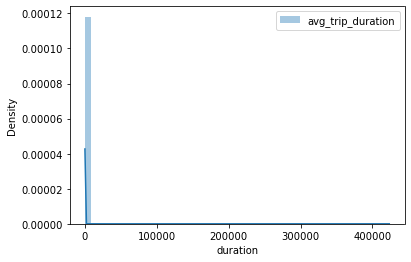

In [126]:
# Check the distribution of the duration variable. There are some outliers.
sns.distplot(df_january.duration, label='avg_trip_duration')
plt.legend()

In [127]:
df_january.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [128]:
# Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
prev_cnt_records = df_january.shape[0]
df_january = df_january[(df_january.duration >= 1) & (df_january.duration <= 60)]
print("We dropped {} records".format(prev_cnt_records - df_january.shape[0]))

We dropped 44286 records


# Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.
But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [129]:
df_january.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000


In [130]:
categorical = ['PUlocationID', 'DOlocationID']
df_january[categorical] = df_january[categorical].fillna(-1)
df_january.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000


In [131]:
pu_nan_frac = 100*df_january[df_january["PUlocationID"]==-1].shape[0]/df_january.shape[0]
print("the fractions of missing values for the pickup location ID equal {}%".format(np.round(pu_nan_frac, 2)))

the fractions of missing values for the pickup location ID equal 83.53%


# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer
* Get a feature matrix from it

In [132]:
categorical = ['PUlocationID', 'DOlocationID']
df_january[categorical] = df_january[categorical].astype(str)

train_dicts = df_january[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print("the dimensionality of matrix(The number of columns) is {}".format(X_train.shape[1]))

the dimensionality of matrix(The number of columns) is 525


# Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters
* Calculate the RMSE of the model on the training data. What's the RMSE on train?

In [133]:
target = 'duration'
y_train = df_january[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse_train = mean_squared_error(y_train, y_pred, squared=False)
print("the RMSE on training is equal to {}".format(np.round(rmse_train, 2)))

the RMSE on training is equal to 10.53


# Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

In [134]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].fillna(-1)
    df[categorical] = df[categorical].astype(str)
    
    return df

In [135]:
#read validation data
df_february = read_dataframe(filename="./data/fhv_tripdata_2021-02.parquet")

In [136]:
categorical = ['PUlocationID', 'DOlocationID']
val_dicts = df_february[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [137]:
y_val = df_february[target].values
y_pred = lr.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred, squared=False)
print("the RMSE on validation is equal to {}".format(np.round(rmse_val, 2)))

the RMSE on validation is equal to 11.01


save the model and dict_vector to binary

In [138]:
import pickle
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)